In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

# Loading Data
Above, we have looked at some simple examples of text analysis with spaCy, but now we’ll be working on some Logistic Regression Classification using scikit-learn. To make this more realistic, we’re going to use a real-world data set—this set of Amazon Alexa product reviews.

This data set comes as a tab-separated file (.tsv). It has has five columns: rating, date, variation, verified_reviews, feedback.

rating denotes the rating each user gave the Alexa (out of 5). date indicates the date of the review, and variation describes which model the user reviewed. verified_reviews contains the text of each review, and feedback contains a sentiment label, with 1 denoting positive sentiment (the user liked it) and 0 denoting negative sentiment (the user didn’t).

This dataset has consumer reviews of amazon Alexa products like Echos, Echo Dots, Alexa Firesticks etc. What we’re going to do is develop a classification model that looks at the review text and predicts whether a review is positive or negative. Since this data set already includes whether a review is positive or negative in the feedback column, we can use those answers to train and test our model. Our goal here is to produce an accurate model that we could then use to process new user reviews and quickly determine whether they were positive or negative.

Let’s start by reading the data into a pandas dataframe and then using the built-in functions of pandas to help us take a closer look at our data.

In [2]:
df_amazon = pd.read_csv("./amazon_alexa.tsv", sep="\t")

In [3]:
df_amazon.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df_amazon.shape

(3150, 5)

In [5]:
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [6]:
df_amazon.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [7]:
df_amazon.feedback.value_counts()

1    2893
0     257
Name: feedback, dtype: int64

# Tokening the Data With spaCy
Now that we know what we’re working with, let’s create a custom tokenizer function using spaCy. We’ll use this function to automatically strip information we don’t need, like stopwords and punctuation, from each review.

We’ll start by importing the English models we need from spaCy, as well as Python’s string module, which contains a helpful list of all punctuation marks that we can use in string.punctuation. We’ll create variables that contain the punctuation marks and stopwords we want to remove, and a parser that runs input through spaCy‘s English module.

Then, we’ll create a spacy_tokenizer() function that accepts a sentence as input and processes the sentence into tokens, performing lemmatization, lowercasing, and removing stop words. This is similar to what we did in the examples earlier in this tutorial, but now we’re putting it all together into a single function for preprocessing each user review we’re analyzing.

In [8]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import spacy

In [11]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [12]:
nlp

In [13]:
len(stop_words)

326

In [14]:
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [15]:
spacy_tokenizer

<function __main__.spacy_tokenizer(sentence)>

In [16]:
spacy_tokenizer(u"Sometimes while playing a game, you can answer")

['play', 'game', 'answer']

In [17]:
nlp.vocab['can'].is_stop

True

# Defining a Custom Transformer
To further clean our text data, we’ll also want to create a custom transformer for removing initial and end spaces and converting text into lower case. Here, we will create a custom predictors class wich inherits the TransformerMixin class. This class overrides the transform, fit and get_parrams methods. We’ll also create a clean_text() function that removes spaces and converts text into lowercase.

In [18]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


In [19]:
# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

## Vectorization Feature Engineering (TF-IDF)
When we classify text, we end up with text snippets matched with their respective labels. But we can’t simply use text strings in our machine learning model; we need a way to convert our text into something that can be represented numerically just like the labels (1 for positive and 0 for negative) are. Classifying text in positive and negative labels is called sentiment analysis. So we need a way to represent our text numerically.

One tool we can use for doing this is called Bag of Words. BoW converts text into the matrix of occurrence of words within a given document. It focuses on whether given words occurred or not in the document, and it generates a matrix that we might see referred to as a BoW matrix or a document term matrix.

We can generate a BoW matrix for our text data by using scikit-learn‘s CountVectorizer. In the code below, we’re telling CountVectorizer to use the custom spacy_tokenizer function we built as its tokenizer, and defining the ngram range we want.

N-grams are combinations of adjacent words in a given text, where n is the number of words that incuded in the tokens. for example, in the sentence “Who will win the football world cup in 2022?” unigrams would be a sequence of single words such as “who”, “will”, “win” and so on. Bigrams would be a sequence of 2 contiguous words such as “who will”, “will win”, and so on. So the ngram_range parameter we’ll use in the code below sets the lower and upper bounds of the our ngrams (we’ll be using unigrams). Then we’ll assign the ngrams to bow_vector.

In [20]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

## TF-IDF (Term Frequency-Inverse Document Frequency)
We’ll also want to look at the TF-IDF (Term Frequency-Inverse Document Frequency) for our terms. This sounds complicated, but it’s simply a way of normalizing our Bag of Words(BoW) by looking at each word’s frequency in comparison to the document frequency. In other words, it’s a way of representing how important a particular term is in the context of a given document, based on how many times the term appears and how many other documents that same term appears in. The higher the TF-IDF, the more important that term is to that document.

We can represent this with the following mathematical equation:

text-classification-python-spacy-math

Of course, we don’t have to calculate that by hand! We can generate TF-IDF automatically using scikit-learn‘s TfidfVectorizer. Again, we’ll tell it to use the custom tokenizer that we built with spaCy, and then we’ll assign the result to the variable tfidf_vector.



In [21]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

## Splitting The Data into Training and Test Sets
We’re trying to build a classification model, but we need a way to know how it’s actually performing. Dividing the dataset into a training set and a test set the tried-and-true method for doing this. We’ll use half of our data set as our training set, which will include the correct answers. Then we’ll test our model using the other half of the data set without giving it the answers, to see how accurately it performs.

Conveniently, scikit-learn gives us a built-in function for doing this: train_test_split(). We just need to tell it the feature set we want it to split (X), the labels we want it to test against (ylabels), and the size we want to use for the test set (represented as a percentage in decimal form).

In [22]:
from sklearn.model_selection import train_test_split

X = df_amazon['verified_reviews'] # the features we want to analyze
ylabels = df_amazon['feedback'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [23]:
len(y_test)

945

## Creating a Pipeline and Generating the Model
Now that we’re all set up, it’s time to actually build our model! We’ll start by importing the LogisticRegression module and creating a LogisticRegression classifier object.

Then, we’ll create a pipeline with three components: a cleaner, a vectorizer, and a classifier. The cleaner uses our predictors class object to clean and preprocess the text. The vectorizer uses countvector objects to create the bag of words matrix for our text. The classifier is an object that performs the logistic regression to classify the sentiments.

Once this pipeline is built, we’ll fit the pipeline components using fit().

In [24]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x000002857299D3A0>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x0000028570BFC160>)),
                ('classifier', LogisticRegression())])

## Evaluating the Model
Let’s take a look at how our model actually performs! We can do this using the metrics module from scikit-learn. Now that we’ve trained our model, we’ll put our test data through the pipeline to come up with predictions. Then we’ll use various functions of the metrics module to look at our model’s accuracy, precision, and recall.

Accuracy refers to the percentage of the total predictions our model makes that are completely correct.
Precision describes the ratio of true positives to true positives plus false positives in our predictions.
Recall describes the ratio of true positives to true positives plus false negatives in our predictions.
The documentation links above offer more details and more precise definitions of each term, but the bottom line is that all three metrics are measured from 0 to 1, where 1 is predicting everything completely correctly. Therefore, the closer our model’s scores are to 1, the better.

In [25]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9333333333333333
Logistic Regression Precision: 0.9405940594059405
Logistic Regression Recall: 0.9895833333333334


In other words, overall, our model correctly identified a comment’s sentiment 92.3% of the time. When it predicted a review was positive, that review was actually positive 93% of the time. When handed a positive review, our model identified it as positive 98.3% of the time

In [26]:
len(y_test)

945

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [28]:
results = confusion_matrix(y_test, predicted)

In [29]:
print(results) 

[[ 27  54]
 [  9 855]]


In [30]:
import matplotlib.pyplot as plt


In [31]:
%matplotlib inline

In [32]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predicted})

In [33]:
df

,Actual,Predicted
720,1,1
1432,1,1
2817,1,1
2961,1,1
3146,1,1
...,...,...
1465,1,1
1495,1,1
936,1,1
1147,0,1


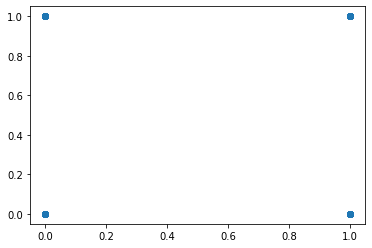

In [34]:
plt.scatter(y_test,predicted)